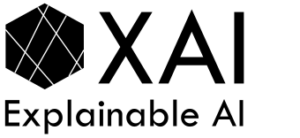

Author: Arun Sharma K

Topic: Explainable AI (XAI)


This python notebooks shows an usecase of explainable tools in AI. The case study focuses on Heart disease prediction using ML and uses techniques listed below to explain the predictions of the ML model

1) Model specific

2) Model agnostic










Steps

1) installation of required packages

2) importing different libraries

3) setting up

4) AutoEDA- Pandas profiling

5) LowcodeML- Pycaret

6) Select Best model

7) Explainability

In [ ]:
# Package to perform AutoEDA
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
# Package for AutoML
#!pip install pycaret

In [5]:
# SHAP tool
#!pip install shap

In [69]:
#Lime tool
!pip install lime

     |████████████████████████████████| 275 kB 10.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=50891670205513bcb8c7a15526ab2cc431ab38b7d604ee7bc5f3bb468b6788ed
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Mar 18 22:11:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [70]:
from google.colab import drive
import os
import pandas as pd
import pandas_profiling
from math import pi
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycaret.classification import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import shap
import lime 
from lime import lime_tabular

In [7]:
MOUNT='/content/drive/'
PROJECT_PATH = "/content/drive/My Drive/GL_PS_XAI"
DATA_FILE_NAME='heart.csv'
TARGET= 'HeartDisease'

In [8]:
drive.mount(MOUNT)

Mounted at /content/drive/


In [9]:
os.chdir(PROJECT_PATH)

In [10]:
df_heart= pd.read_csv(DATA_FILE_NAME)

In [11]:
df_heart.sample(10)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
254   55   M           ASY        145          248          0     Normal   
694   56   M           ATA        120          236          0     Normal   
759   54   M           ATA        192          283          0        LVH   
823   64   M           NAP        125          309          0     Normal   
874   43   M           ASY        150          247          0     Normal   
19    36   M           ATA        120          267          0     Normal   
463   51   M           ASY        128            0          0     Normal   
4     54   M           NAP        150          195          0     Normal   
779   43   M           ASY        110          211          0     Normal   
531   64   M           ASY        143          306          1         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
254     96              Y      2.0     Flat             1  
694    178              N      0.8       Up             0  
759    195              N      0.0       Up             1  
823    131              Y      1.8     Flat             1  
874    171              N      1.5       Up             0  
19     160              N      3.0     Flat             1  
463    107              N      0.0       Up             0  
4      122              N      0.0       Up             0  
779    161              N      0.0       Up             0  
531    115              Y      1.8     Flat             1

In [12]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [13]:
num_var=list(df_heart._get_numeric_data().columns[:-1])
cat_var=list(set(df_heart.columns[:-1]) - set(num_var))

In [14]:
num_var

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [15]:
cat_var

['RestingECG', 'Sex', 'ExerciseAngina', 'ST_Slope', 'ChestPainType']

In [16]:
profile =pandas_profiling.ProfileReport(df_heart)

About the varibles

Target

HeartDisease	output class	1 = heart disease, 0 = Normal

______________
Attributes


Age (Numeric): Age of the person in years

sex (Categorical): Gender Mal/Female

chestpain (categoical): 
*   TA = Typical Angina
*   ATA = Atypical Angina
*   NAP = Non-Anginal Pain
*   ASY = Asymptomatic

RestingBP(Numeric) [mm-Hg]: blood pressure when the person is at rest

Cholesterol(Numeric) [mg/dl]: Cholestrol level in the blood

FastingBS (Encoded Categorical):fasting blood sugar	1 = if FastingBS > 120 mg/dl, 0 = otherwise

RestingECG (categorical): electrocardiogram results while the patient is at rest	
*   Normal = Normal
*   ST = having ST-T wave abnormality
*   LVH = showing probable or definite left ventricular hypertrophy

MaxHR (Numerical): Maximum heart rate recorded

ExerciseAngina (Categorical):	exercise-induced angina	
*   Y
*   N

Oldpeak (Numerical): Old peak = ST depression induced by exercise relative to rest

ST_slope(Categorical):















 
 


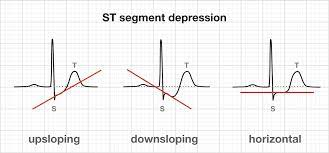

In [17]:
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

In [104]:
s = setup(df_heart, target = TARGET, use_gpu=True )

Description             Value
0                               session_id              7078
1                                   Target      HeartDisease
2                              Target Type            Binary
3                            Label Encoded              None
4                            Original Data         (918, 12)
5                           Missing Values             False
6                         Numeric Features                 5
7                     Categorical Features                 6
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set         (642, 18)
12                    Transformed Test Set         (276, 18)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              d437
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

In [105]:
best = compare_models( )

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.8597  0.9221  0.8847  0.8669   
ridge                    Ridge Classifier    0.8567  0.0000  0.8846  0.8614   
lda          Linear Discriminant Analysis    0.8551  0.9214  0.8846  0.8589   
rf               Random Forest Classifier    0.8504  0.9211  0.8761  0.8594   
gbc          Gradient Boosting Classifier    0.8488  0.9157  0.8672  0.8620   
nb                            Naive Bayes    0.8442  0.9085  0.8563  0.8635   
lightgbm  Light Gradient Boosting Machine    0.8426  0.9170  0.8678  0.8527   
et                 Extra Trees Classifier    0.8411  0.9167  0.8593  0.8572   
ada                  Ada Boost Classifier    0.8317  0.8709  0.8621  0.8412   
dt               Decision Tree Classifier    0.7773  0.7783  0.7698  0.8208   
knn                K Neighbors Classifier    0.6699  0.7092  0.7328  0.6928   
qda       Quadratic Discriminant Analysis    0.6435  0.6422  0.6462  0.7303   
svm                   SVM - Linear Kernel    0.6325  0.0000  0.7848  0.7070   
dummy                    Dummy Classifier    0.5545  0.5000  1.0000  0.5545   

              F1   Kappa     MCC  TT (Sec)  
lr        0.8745  0.7155  0.7183     0.347  
ridge     0.8719  0.7091  0.7116     0.012  
lda       0.8706  0.7058  0.7083     0.016  
rf        0.8664  0.6964  0.6993     0.807  
gbc       0.8626  0.6941  0.6977     0.132  
nb        0.8583  0.6848  0.6881     0.011  
lightgbm  0.8592  0.6808  0.6830     0.054  
et        0.8565  0.6782  0.6817     0.803  
ada       0.8497  0.6583  0.6622     0.105  
dt        0.7929  0.5523  0.5560     0.011  
knn       0.7102  0.3258  0.3291     0.025  
qda       0.6208  0.2873  0.3194     0.010  
svm       0.6724  0.2278  0.2767     0.011  
dummy     0.7134  0.0000  0.0000     0.006

In [106]:
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7078, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [107]:
lr=create_model('lr')
tuned_lr_classifier=tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8615  0.9550  0.8889  0.8649  0.8767  0.7189  0.7192
1       0.9077  0.9416  0.9444  0.8947  0.9189  0.8120  0.8136
2       0.8750  0.8710  0.9167  0.8684  0.8919  0.7440  0.7455
3       0.8750  0.9296  0.8889  0.8889  0.8889  0.7460  0.7460
4       0.8594  0.9435  0.8333  0.9091  0.8696  0.7176  0.7208
5       0.8906  0.9315  0.8889  0.9143  0.9014  0.7787  0.7790
6       0.8438  0.9044  0.8000  0.9032  0.8485  0.6884  0.6938
7       0.8281  0.8897  0.8857  0.8158  0.8493  0.6501  0.6531
8       0.8906  0.9478  0.9714  0.8500  0.9067  0.7760  0.7861
9       0.7969  0.9034  0.7429  0.8667  0.8000  0.5961  0.6034
Mean    0.8629  0.9217  0.8761  0.8776  0.8752  0.7228  0.7261
SD      0.0313  0.0265  0.0643  0.0289  0.0334  0.0612  0.0603

In [108]:
print (tuned_lr_classifier)

LogisticRegression(C=5.491000000000001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7078, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [109]:
x_cat=pd.get_dummies(df_heart[cat_var])

In [19]:
x_cat.shape

(918, 14)

In [20]:
sclr=MinMaxScaler()

In [21]:
X=df_heart[num_var].join(x_cat)
X.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  RestingECG_LVH  \
0   40        140          289          0    172      0.0               0   
1   49        160          180          0    156      1.0               0   
2   37        130          283          0     98      0.0               0   
3   48        138          214          0    108      1.5               0   
4   54        150          195          0    122      0.0               0   

   RestingECG_Normal  RestingECG_ST  Sex_F  Sex_M  ExerciseAngina_N  \
0                  1              0      0      1                 1   
1                  1              0      1      0                 1   
2                  0              1      0      1                 1   
3                  1              0      1      0                 0   
4                  1              0      0      1                 1   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  \
0                 0              0              0            1   
1                 0              0              1            0   
2                 0              0              0            1   
3                 1              0              1            0   
4                 0              0              0            1   

   ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  
0                  0                  1                  0                 0  
1                  0                  0                  1                 0  
2                  0                  1                  0                 0  
3                  1                  0                  0                 0  
4                  0                  0                  1                 0

In [22]:
y=df_heart[TARGET]

In [23]:
 X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=5)

In [111]:
X_train[num_var]=sclr.fit_transform(X_train[num_var])
X_test[num_var]=sclr.transform(X_test[num_var])

In [112]:
lr_best=LogisticRegression(C=5.491, class_weight={}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2048, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
lr_best.fit(X_train,y_train)

LogisticRegression(C=5.491, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2048, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
print ("accuracy on train samples", round(lr_best.score(X_train,y_train),2)*100)
print ("accuracy on test samples", round(lr_best.score(X_test,y_test),2)*100)

accuracy on train samples 85.0
accuracy on test samples 84.0


In [115]:
df_heart.iloc[[151,448]]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
151   48   M           ATA        100          159          0     Normal   
448   63   M           ASY        160          230          1     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
151    100              N      0.0       Up             0  
448    105              Y      1.0     Flat             1

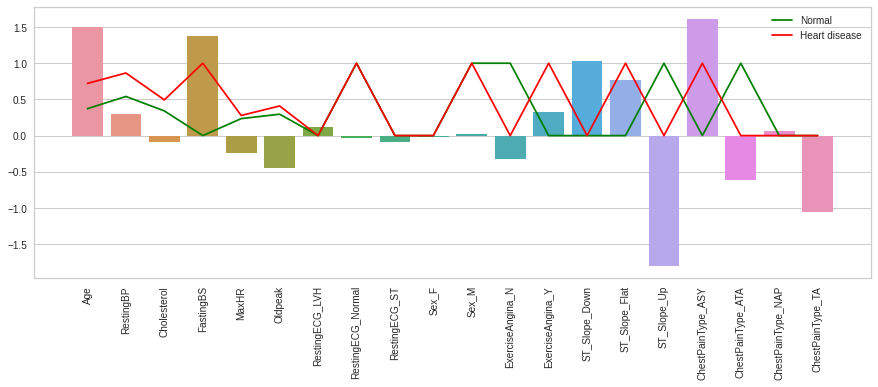

In [116]:
plt.figure(figsize=(15, 5))
sns.barplot(x=X.columns, y=lr_best.coef_.flatten().tolist());
plt.xticks(rotation=90);
sns.lineplot(x=X.columns, y=X_test.iloc[[1]].values.flatten().tolist(),color='green', label='Normal');
sns.lineplot(x=X.columns, y=X_test.iloc[[10]].values.flatten().tolist(),color='red',  label='Heart disease');

In [117]:
X_test2=X_test.join(y_test)
reflist=[]
for i in df_heart[TARGET].unique():
  num_ref=X_test2[X_test2[TARGET]==i][num_var].median().values
  cat_ref=X_test2[X_test2[TARGET]==i][list(x_cat.columns)].mode().values.astype('int')
  print (np.append(num_ref, cat_ref))
  reflist.append(np.append(num_ref, cat_ref))
  

[0.44186047 0.7027027  0.49356223 0.         0.66956522 0.29545455
 0.         1.         0.         0.         1.         1.
 0.         0.         0.         1.         0.         0.
 0.         0.        ]
[0.58139535 0.70810811 0.45493562 0.         0.45217391 0.43181818
 0.         1.         0.         0.         1.         0.
 1.         0.         1.         0.         1.         0.
 0.         0.        ]


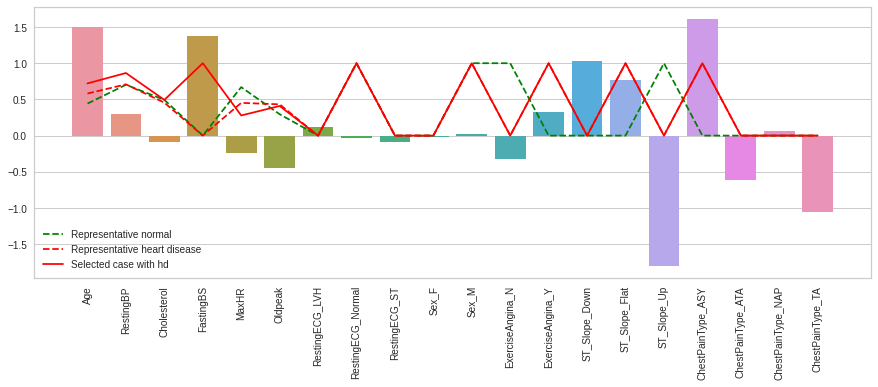

In [118]:
plt.figure(figsize=(15, 5))
sns.barplot(x=X.columns, y=lr_best.coef_.flatten().tolist());
plt.xticks(rotation=90);
sns.lineplot(x=X.columns, y=reflist[0],color='green',linestyle='--', label='Representative normal');
sns.lineplot(x=X.columns, y=reflist[1],color='red',linestyle='--',  label='Representative heart disease');
sns.lineplot(x=X.columns, y=X_test.iloc[[10]].values.flatten().tolist(),color='red',  label='Selected case with hd');

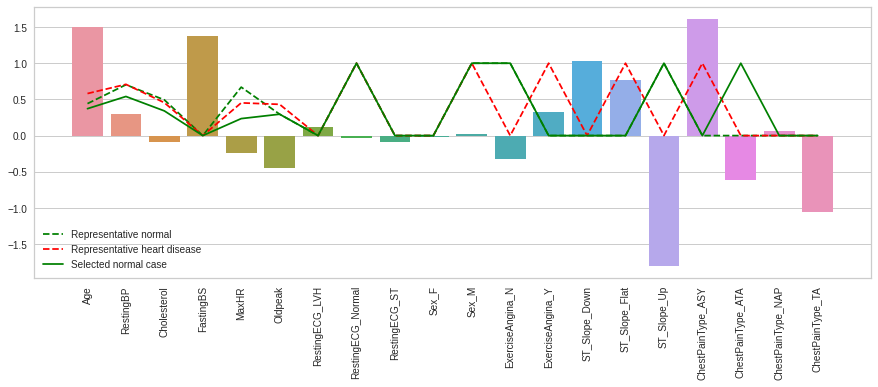

In [119]:
plt.figure(figsize=(15, 5))
sns.barplot(x=X.columns, y=lr_best.coef_.flatten().tolist());
plt.xticks(rotation=90);
sns.lineplot(x=X.columns, y=reflist[0],color='green',linestyle='--', label='Representative normal');
sns.lineplot(x=X.columns, y=reflist[1],color='red',linestyle='--',  label='Representative heart disease');
sns.lineplot(x=X.columns, y=X_test.iloc[[1]].values.flatten().tolist(),color='green',  label='Selected normal case');

In [120]:
indx1=1
index2=10
df= X_test.iloc[[indx1,index2]].join(y_test.iloc[[indx1,index2]])

In [121]:
df

Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
151  0.372093   0.540541     0.341202        0.0  0.234783  0.295455   
448  0.720930   0.864865     0.493562        1.0  0.278261  0.409091   

     RestingECG_LVH  RestingECG_Normal  RestingECG_ST  Sex_F  ...  \
151               0                  1              0      0  ...   
448               0                  1              0      0  ...   

     ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  \
151                 1                 0              0              0   
448                 0                 1              0              1   

     ST_Slope_Up  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
151            1                  0                  1                  0   
448            0                  1                  0                  0   

     ChestPainType_TA  HeartDisease  
151                 0             0  
448                 0             1  

[2 rows x 21 columns]

In [122]:
lr_best.predict(X_test.iloc[[indx1,index2]])

array([0, 1])

### Model agnostic
Radar plot

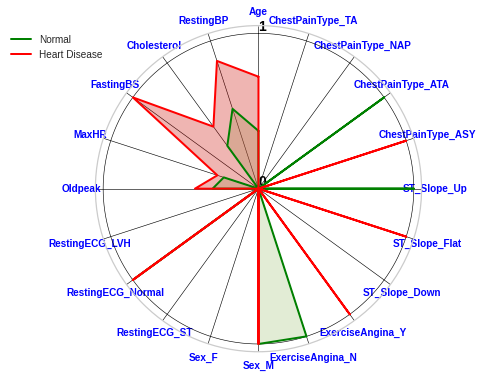

In [123]:
plt.figure(figsize=(6,6))
# number of variable
categories=list(df[X_test.columns])
N = len(categories)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='blue', weight='bold')
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,1], ["0","1"], color="black", size=14, weight='bold' )
plt.ylim(0,1.05)
plt.grid(color='black', linewidth=0.6)
# ------- PART 2: Add plots
# Mormal
values=df[X_test.columns].iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, color='green', linestyle='solid', label="Normal")
ax.fill(angles, values, 'g', alpha=0.3)
# Heart Disease
values=df[X_test.columns].iloc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2,color='red', linestyle='solid', label="Heart Disease")
ax.fill(angles, values, 'r', alpha=0.3)
# Add legend
plt.legend(bbox_to_anchor=(0.05, 1))

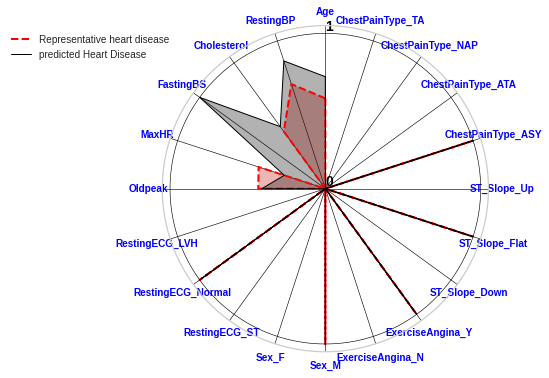

In [124]:
plt.figure(figsize=(6,6))
# number of variable
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='blue', weight='bold')
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,1], ["0","1"], color="black", size=14, weight='bold' )
plt.ylim(0,1.05)
plt.grid(color='black', linewidth=0.6)
# ------- PART 2: Add plots
values=reflist[1].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, color='red', linestyle='dashed', label="Representative heart disease")
ax.fill(angles, values, 'r', alpha=0.3)
values=df[X_test.columns].iloc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1,color='black', linestyle='solid', label="predicted Heart Disease")
ax.fill(angles, values, 'black', alpha=0.3)
# Add legend
plt.legend(bbox_to_anchor=(0.05, 1))

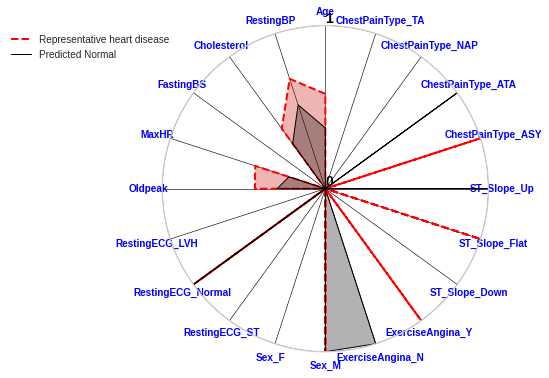

In [125]:
plt.figure(figsize=(6,6))
# number of variable
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='blue', weight='bold')
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,1], ["0","1"], color="black", size=14, weight='bold' )
plt.ylim(0,1)
plt.grid(color='black', linewidth=0.6)
# ------- PART 2: Add plots
values=reflist[1].tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, color='red', linestyle='dashed', label="Representative heart disease")
ax.fill(angles, values, 'r', alpha=0.3)
# Normal
values=df[X_test.columns].iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color='black', linestyle='solid', label="Predicted Normal")
ax.fill(angles, values, 'black', alpha=0.3)
# Add legend
plt.legend(bbox_to_anchor=(0.05, 1))

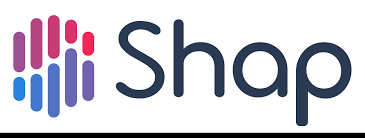



*   KernalSHAP
*   TreeSHAP
*   DeepSHAP





In [126]:
y_proba=lr_best.predict_proba(X_test)

In [139]:
explainer = shap.Explainer(lr_best, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

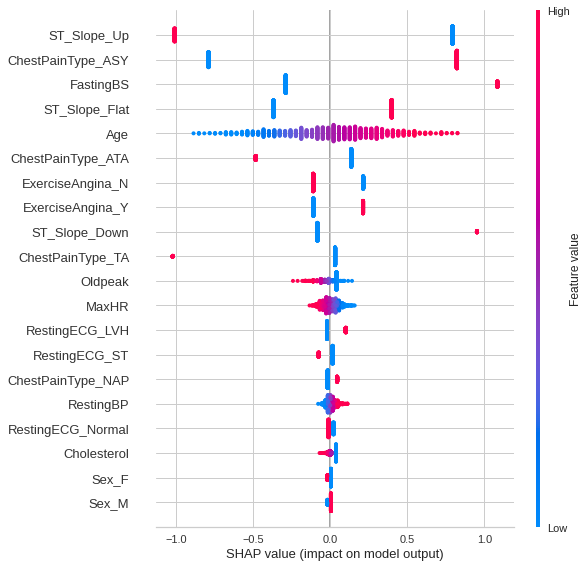

In [128]:
s2=shap.plots.beeswarm(shap_values, max_display=20)

### Plot Interpretation ( overall model)

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation:

*   higher value of ST_Slope_up has negetive impact ( lower the probability of HD)
*   Higher value of Chestpaintype_ASY has positive impact ( increase the probability of HD)
*   Higher value of Fasting_BS has positive impact (increase the probability of HD)









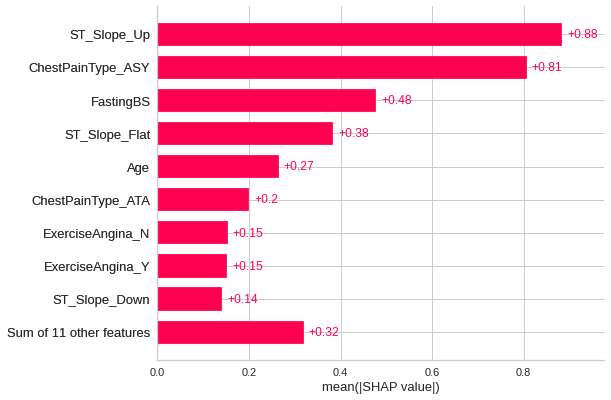

In [129]:
shap.plots.bar(shap_values)

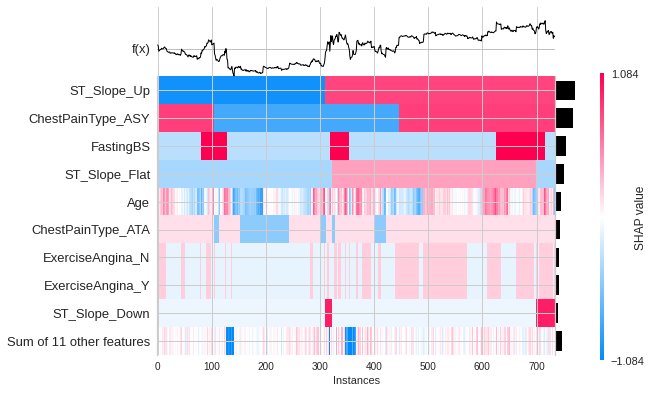

In [130]:
shap.plots.heatmap(shap_values)

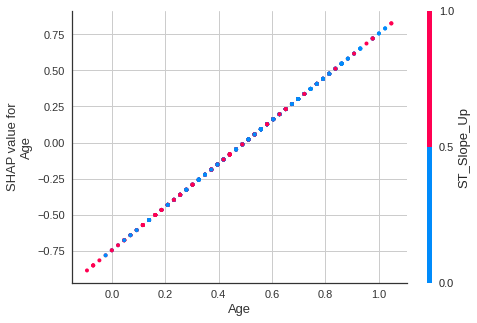

In [131]:
shap_values_2 = shap_values = explainer.shap_values(X_test)
shap.dependence_plot("Age", shap_values_2, X_test)

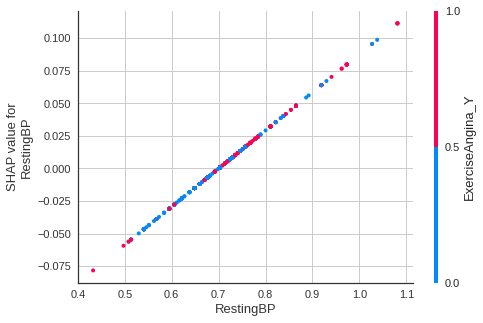

In [132]:
shap.dependence_plot("RestingBP", shap_values_2, X_test)

In [133]:
X_test.iloc[[1, 10]]

Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
151  0.372093   0.540541     0.341202        0.0  0.234783  0.295455   
448  0.720930   0.864865     0.493562        1.0  0.278261  0.409091   

     RestingECG_LVH  RestingECG_Normal  RestingECG_ST  Sex_F  Sex_M  \
151               0                  1              0      0      1   
448               0                  1              0      0      1   

     ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  \
151                 1                 0              0              0   
448                 0                 1              0              1   

     ST_Slope_Up  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
151            1                  0                  1                  0   
448            0                  1                  0                  0   

     ChestPainType_TA  
151                 0  
448                 0

In [134]:
df_heart.iloc[[151,448]]

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
151   48   M           ATA        100          159          0     Normal   
448   63   M           ASY        160          230          1     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
151    100              N      0.0       Up             0  
448    105              Y      1.0     Flat             1

In [135]:
print ('predited lable',lr_best.predict(X_test.iloc[[10]]))
print ('predited probability',lr_best.predict_proba(X_test.iloc[[10]]))
print (1/(1+np.exp(-1*np.log(4.21))))
print ('Actual lable', y_test.iloc[[10]])
print ("The person has heart Disease")

predited lable [1]
predited probability [[0.01683211 0.98316789]]
0.8080614203454896
Actual lable 448    1
Name: HeartDisease, dtype: int64
The person has heart Disease


In [141]:
shap.initjs()
shap.plots.force(shap_values[10])

###Plot Interpretation


*   base value: Average of the predictions for training data
*   predicted value for the instance: bold number
*   blue indicates: features pushing to 0 (lower log(odds))
*   red indicates: features pushing to 1 (higher log(odds))
*   contribution proportional to strength









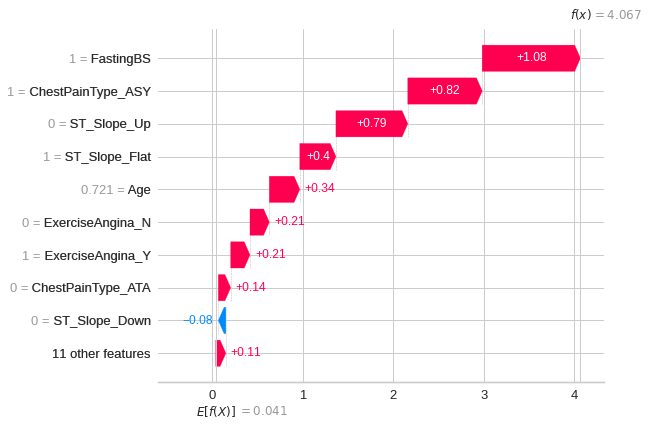

In [142]:
shap.plots.waterfall(shap_values[10])

In [143]:
print ('predited lable',lr_best.predict(X_test.iloc[[12]]))
print ('predited probability',lr_best.predict_proba(X_test.iloc[[12]]))
print (1/(1+np.exp(-1*np.log(2.17))))
print ('Actual lable', y_test.iloc[[12]])
print ("The person has heart disease")

predited lable [1]
predited probability [[0.10266793 0.89733207]]
0.6845425867507886
Actual lable 244    1
Name: HeartDisease, dtype: int64
The person has heart disease


In [144]:
shap.initjs()
shap.plots.force(shap_values[12])

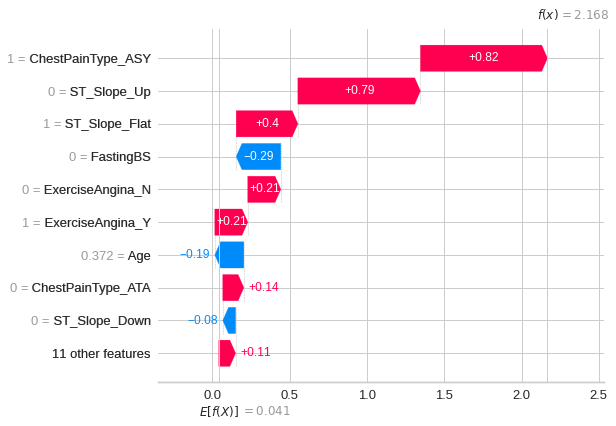

In [145]:
shap.plots.waterfall(shap_values[12])

In [146]:
print ('predited lable',lr_best.predict(X_test.iloc[[1]]))
print ('predited probability',lr_best.predict_proba(X_test.iloc[[1]]))
print ('Actual lable', y_test.iloc[[1]])
print ("The person is normal")

predited lable [0]
predited probability [[0.96435316 0.03564684]]
Actual lable 151    0
Name: HeartDisease, dtype: int64
The person is normal


In [147]:
shap.initjs()
shap.plots.force(shap_values[1])

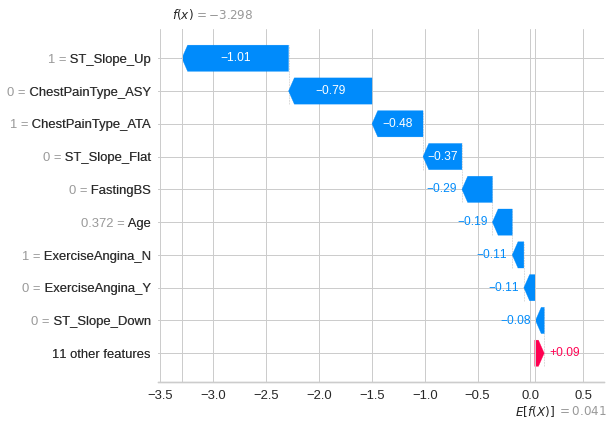

In [148]:
shap.plots.waterfall(shap_values[1])

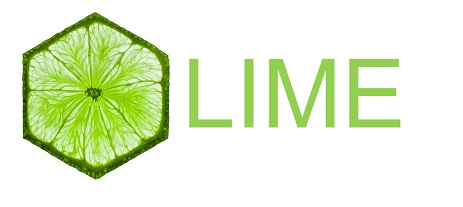

 LIME has  three explainers


*   Tabular explainer (which we will focus on)
 
*   Image explainer

*   Text explainer 





 
  
 


In [149]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Normal', 'Heart Disease'],
    mode='classification')

In [150]:
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=lr_best.predict_proba)
lime_exp.show_in_notebook(show_table=True)

In [151]:
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[10],
    predict_fn=lr_best.predict_proba)
lime_exp.show_in_notebook(show_table=True)